# Using the readout emulator code

There are some basic attributes to an event, at various levels:

**Gas/Detector Info**: The readout emulation code needs the parameters of the gas and detector. *Gas parameters*; z and x/y diffusion coefficients, the mobilities, and the W value. *Detector Parameters*; drift field, total avalanche gain and gain variance (stored as a probability distribution), total avalanche region point spread function (TODO: generalise this to a x/y/t PSF. I could just treat t as uncorrelated and add a Gaussian smear?), the readout pitch and sampling rate. Note that 'total' GEM gain/PSF means if we're using a 3x GEM stack it'll be the 3x convolution of the single GEM gain/PSF. *Future updates*; drift field distortions, the photon light yield (primary and secondary), charge sharing/crosstalk between readout channels, readout digitization/noise.

**Simulation**: Everything returned by Geant4. As a minimum this is the energy deposits and their locations in the gas. But it could also include the particle ID, primary particle information, and other things. The primary track data is the thing which is needed by the rest of this code. 

* Stored as PrimaryEvt(x,y,z,Edep). May also include things like the vertex location.

**Charge carrier generation**: Poisson-sample the number of electron-ion pairs using the W value. 

* PrimaryEvt modified to be PrimaryEvt(x,y,z, Edep, # carriers)

**Drift down to the readout plane**: Work out what $\sigma_{x/y}$ and $\sigma_{z}$ are, and sample them for every carrier. This makes a new array in memory.

* Stored as DriftedEvt(index in PrimaryEvt, x, y, delta_t)

**Sample avalanche gain**: For each drifted carrier, 1. use the gain distribution to sample a total number of electrons $N_e$, and 2. multiply the PSF by $N_e$ at that location and add to the output. It would be too slow the sample the PSF $N_e$ times, since $N_e \sim 10^5$ or so. Then add the locations of the electrons to a histogram with a pitch given by the readout pitch, and with time binned according to the sampling rate. The histogram range should just be enough to cover the extent of the event, perhaps above some noise threshold (since the PSF may have a long tail). Only keep events above some threshold number of $N_e$.

* Stored as ReadoutEvt(x,y,dt,Nelectrons) where the x/y/dt co-ordinates are constrained to the readout pitch of the detector.

Open questions: 
* Is there a correlation between the x/y diffusion or PSF and the t diffusion or PSF? How can I best account for this?
* How can we implement a more realistic PSF on the readout plane without slowing things down?
* How do we handle very finely pitched readouts?
* Should we use Xarray instead of pandas (easier to generalise to more dimensions)?
* Should we try to distribute the energy deposit along the Geant4 step? (Currently it is placed at the post-step point).

In [2]:
%pylab
%matplotlib inline
import pandas as pd
import numpy as np

Using matplotlib backend: <object object at 0x7ff8940b26c0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [4]:
from ROOT import TFile, TTree

Welcome to JupyROOT 6.28/00


For now, I'll use pandas dataframes to create the PrimaryEvt and DriftedEvt structures

# Base units

The default Geant4 units are janky, so I'll avoid those.

Instead, I'll use:

Length -- cm

Energy -- keV

time -- seconds


# Simulation

Let's make a straight line energy deposit originating at (5 cm, 5 cm, 5 cm), along a vector pointing 45 degrees between x and y, and 45 degrees inclined towards z. Energy deposits are equally spaced at 1 mm, and decreasing in intensity from 10 keV in 1 keV increments at each deposit.

In [5]:
vertex = (5,5,5)
theta = (np.pi/4)
phi = (np.pi/4)
Ed_prim = np.arange(10,0,-1)
steplen = 0.1
x_prim = [vertex[0] + i*steplen*np.sin(theta)*np.cos(phi) for i in range(len(Ed_prim))]
y_prim = [vertex[0] + i*steplen*np.sin(theta)*np.sin(phi) for i in range(len(Ed_prim))]
z_prim = [vertex[0] + i*steplen*np.cos(theta) for i in range(len(Ed_prim))]

In [6]:
PrimaryEvt = pd.DataFrame({'x':x_prim, 'y':y_prim, 'z':z_prim, 'Edep': Ed_prim})

In [7]:
PrimaryEvt

,x,y,z,Edep
0,5.00,5.00,5.000000,10
1,5.05,5.05,5.070711,9
2,5.10,5.10,5.141421,8
3,5.15,5.15,5.212132,7
4,5.20,5.20,5.282843,6
5,5.25,5.25,5.353553,5
6,5.30,5.30,5.424264,4
7,5.35,5.35,5.494975,3
8,5.40,5.40,5.565685,2
9,5.45,5.45,5.636396,1


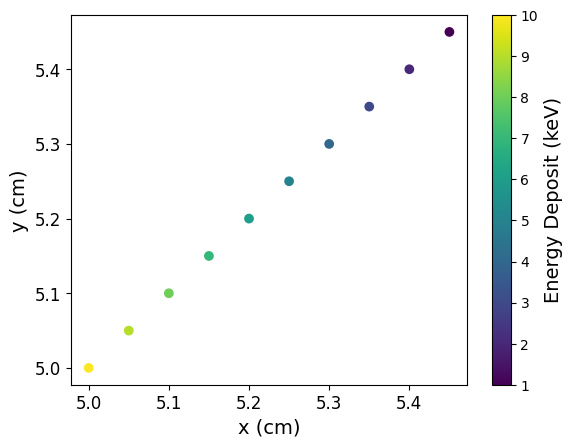

In [8]:
plt.scatter(PrimaryEvt['x'], PrimaryEvt['y'], c=PrimaryEvt['Edep']);
plt.xlabel('x (cm)', fontsize=14)
plt.ylabel('y (cm)', fontsize=14)
cb = plt.colorbar(label='Energy Deposit (keV)')
cb.set_label('Energy Deposit (keV)', fontsize=14)
# plt.title('X-Y projection')
ax = plt.gca()
ax.tick_params(labelsize=12)
plt.savefig('ReadoutExample_primary.png', dpi=400)

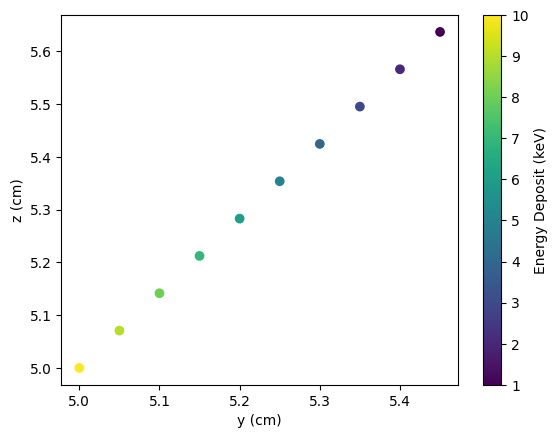

In [9]:
plt.scatter(PrimaryEvt['y'], PrimaryEvt['z'], c=PrimaryEvt['Edep']);
plt.xlabel('y (cm)')
plt.ylabel('z (cm)')
plt.colorbar(label='Energy Deposit (keV)')

OK, that's fairly trivial. In reality we'll need to make a ROOT file reader or whatever. But for now let's just proceed.

# Gas/Detector Info

Diffusion goes as $\sigma = \sqrt{2Dt}$ and mobility is the proportionality constant between the drift velocity and the **E** field.

I'll use the values for Ar gas

In [10]:
w_value = 26.4/1000 #keV/ion pair, Med Phys 4R06/6R03 Radioisotopes and Radiation Methodology

Diffcoeff_xy = 0.04 #cm^2/s, from Sauli's textbook pg 82

Diffcoeff_z = 0.04 #cm^2/s, from Sauli's textbook pg 82

mobility = 1.7 #cm^2V^-1s^-1 from Sauli's textbook pg 87

DriftField = 100 #V/cm

pitch_x = 0.1 #cm
pitch_y = 0.1 #cm
sample_rate = 1e-3#seconds

**Gain and gain variance**: According to Sauli (pg 151), the number of electrons in an avalanche is given by a Poisson distribution:

$P(n,N) = \frac{1}{\bar{n}}(\frac{n}{\bar{n}})^{N-1}\frac{e^{-\frac{n}{\bar{n}}}}{(N-1)!}$,

where $N$ is the number of primary electrons $n$ is the number of electrons in the avalanche, and $\bar{n}$ is the mean number of electrons in the avalanche.

If we start with 1 electron, this means the gain is exponentially distributed, and the most probable value is 0. If we have 3x GEMs, we'll start with N electrons and need to sample again. Interesting...

Also, Peter's simulations (https://darkmatteraustralia.atlassian.net/wiki/spaces/CYG/pages/362708993/15+10+2020) of a single GEM don't show an exponential distribution.

For now, I'll just go with an exponentially distributed gain.

**GEM PSF PDF**: it's best to use the GarField PDF, but for now I will just use a truncated normal distribution. The code may slow down once I start sampling a (non-optimised) custom histogram.

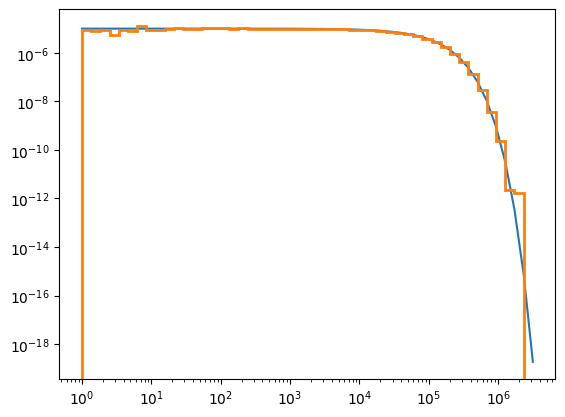

In [11]:
meangain = 10**5
xvals = np.logspace(0,6.5,50)
yvals = np.exp(-xvals/meangain)/meangain
plt.plot(xvals, yvals)
plt.xscale('log')
plt.yscale('log')
poisson_rvs = np.random.exponential(scale=meangain, size=int(1e6))
rets = plt.hist(poisson_rvs, histtype='step', bins=xvals, density=True, lw=2);

In [12]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10, nsamp=1):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(size=nsamp)

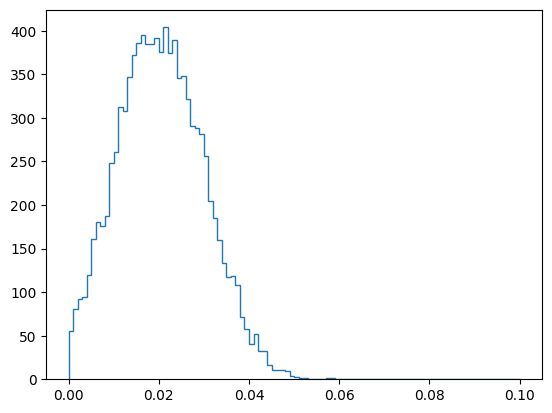

In [13]:
plt.hist(get_truncated_normal(mean=0.02, sd=0.01, low=0, upp=np.inf, nsamp=int(1e4)), histtype='step', 
         bins=100, range=(0, 0.1));

In [14]:
gain_mean = 10**5
#gain_variance will be samples of np.random.exponential(scale=meangain)
PSF_mean=0.02 #cm
PSF_std=0.01 #cm
readout_sigma_t = 10**-8 #seconds

# Charge Carrier Generation

Need to add a column to the pandas dataframe with the Poisson-sampled NIPs.

In [15]:
PrimaryEvt['NIP'] = np.random.poisson(PrimaryEvt['Edep']/w_value)

In [16]:
PrimaryEvt

,x,y,z,Edep,NIP
0,5.00,5.00,5.000000,10,397
1,5.05,5.05,5.070711,9,349
2,5.10,5.10,5.141421,8,305
3,5.15,5.15,5.212132,7,260
4,5.20,5.20,5.282843,6,224
5,5.25,5.25,5.353553,5,200
6,5.30,5.30,5.424264,4,157
7,5.35,5.35,5.494975,3,111
8,5.40,5.40,5.565685,2,72
9,5.45,5.45,5.636396,1,34


In [17]:
PrimaryEvt['Edep'].sum()

55

# Drift to Readout Plane

I can probably speed this up if I try.

Is there a sql-type trick to play here? Each row in PrimaryEvt will have NIP rows in the DriftedEvt dataframe.

Currently it takes about 2 ms to process ~2000 NIPs, which is from a 55 keV primary energy deposit.

To process 100 000 simulated events, this would take 100 seconds.

Not awful, but not great...

In [18]:
def driftvel(E,mu):
    #Mobility is the proportionality constant between the E field and the velocity
    return mu*E
def driftsigma(z, D, E, mu):
    #drift sigma = sqrt(2*diffusion*deltaT)
    avg_deltat = z/driftvel(E, mu)
    return np.sqrt(2*avg_deltat*D)

In [19]:
PrimaryEvt['NIP'].sum()

2109

In [22]:
%%timeit
ret = np.random.normal(loc=0, scale=driftsigma(PrimaryEvt['z'][9], Diffcoeff_xy, DriftField, mobility), 
                        size=(PrimaryEvt['NIP'][9], 2))

10.2 µs ± 288 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [21]:
%%timeit
num_to_drift = PrimaryEvt['NIP'][9]
ret = np.random.normal(loc=0, scale=driftsigma(num_to_drift, Diffcoeff_xy, DriftField, mobility), 
                        size=(num_to_drift, 2))

8.85 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [37]:
%%timeit
ret = np.random.normal(loc=0, scale=driftsigma(PrimaryEvt['z'][9], Diffcoeff_xy, DriftField, mobility), 
                        size=(PrimaryEvt['NIP'][9]))
ret = np.random.normal(loc=0, scale=driftsigma(PrimaryEvt['z'][9], Diffcoeff_xy, DriftField, mobility), 
                        size=(PrimaryEvt['NIP'][9]))

17.3 µs ± 632 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [25]:
%%time
Ndrifted = PrimaryEvt['NIP'].sum()
drifteddict = {'idx_Primary': np.empty(Ndrifted, dtype=np.int32), 'x': np.empty(Ndrifted, dtype=np.float32),
              'y': np.empty(Ndrifted, dtype=np.float32), 'dt': np.empty(Ndrifted, dtype=np.float32)}
counter = 0
vd = driftvel(DriftField, mobility)
for i in range(len(PrimaryEvt)):
    numtodrift = PrimaryEvt['NIP'][i]
    #print(numtodrift)
    thisz = PrimaryEvt['z'][i]
    #print(thisz)
    drifteddict['idx_Primary'][counter:(counter+numtodrift)] = i
    #print(driftsigma(thisz, Diffcoeff_xy, DriftField, mobility))
    drifteddict['x'][counter:(counter+numtodrift)] = PrimaryEvt['x'][i] + np.random.normal(loc=0, 
                                                            scale=driftsigma(thisz, Diffcoeff_xy, 
                                                                             DriftField, mobility),
                                                            size=numtodrift)
    drifteddict['y'][counter:(counter+numtodrift)] = PrimaryEvt['y'][i] + np.random.normal(loc=0, 
                                                            scale=driftsigma(thisz, Diffcoeff_xy, 
                                                                             DriftField, mobility),
                                                            size=numtodrift)
    drifteddict['dt'][counter:(counter+numtodrift)] = (thisz + np.random.normal(loc=0, 
                                                            scale=driftsigma(thisz, Diffcoeff_z, 
                                                                             DriftField, mobility),
                                                            size=numtodrift))/vd
    counter += numtodrift

DriftedEvt = pd.DataFrame(drifteddict)

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 2.34 ms


In [26]:
DriftedEvt

,idx_Primary,x,y,dt
0,0,5.100634,5.021656,0.029513
1,0,5.068022,4.949405,0.029250
2,0,5.061503,4.983319,0.029339
3,0,4.957842,5.000828,0.029423
4,0,4.969149,4.990558,0.028993
...,...,...,...,...
2104,9,5.538059,5.435692,0.032614
2105,9,5.395759,5.424811,0.032516
2106,9,5.508862,5.454083,0.033370
2107,9,5.442463,5.374358,0.033482


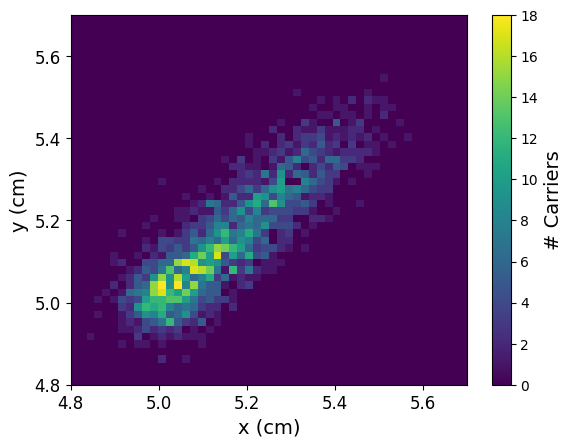

In [27]:
plt.hist2d(DriftedEvt['x'], DriftedEvt['y'], range=((4.8,5.7),(4.8, 5.7)), bins=(50,50));
plt.xlabel('x (cm)', fontsize=14)
plt.ylabel('y (cm)', fontsize=14)
cb = plt.colorbar(label='# carriers')
cb.set_label('# Carriers', fontsize=14)
# plt.title('X-Y projection')
ax = plt.gca()
ax.tick_params(labelsize=12)
plt.savefig('ReadoutExample_drifted.png', dpi=400)

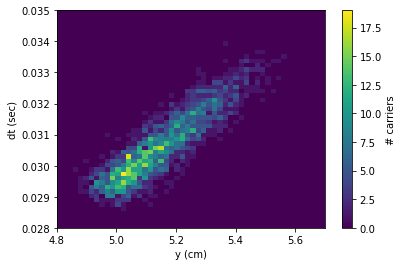

In [ ]:
plt.hist2d(DriftedEvt['y'], DriftedEvt['dt'], range=((4.8,5.7),(0.028, 0.035)), bins=(50,50));
plt.xlabel('y (cm)')
plt.ylabel('dt (sec)')
plt.colorbar(label='# carriers')

Nice!

# Sample Avalanche Gain

For each drifted carrier,  1. use the gain distribution to sample a total number of electrons $𝑁_𝑒$, and 2. ~~sample the point spread function $𝑁_𝑒$ times~~ Multiply the PSF by 𝑁𝑒 at that location. It would be too slow the sample the PSF $𝑁_𝑒$ times, since $𝑁_𝑒 \sim 10^5$ or so. Then add the locations of the electrons to a histogram with a pitch given by the readout pitch, and with time binned according to the sampling rate. The histogram range should just be enough to cover the extent of the event, perhaps above some noise threshold (since the PSF may have a long tail).

* Stored as a 3D array made using numpy.histogramdd, where the bin edges are determined by the readout pitch.


In [ ]:
minvals = DriftedEvt.min()
maxvals = DriftedEvt.max()
#prepare a 3D histogram of x/y/z
#NOTE THAT THIS IS NON-STANDARD AS IT USES BIN CENTRES RATHER THAN BIN EDGES!!
readout_x = np.arange(np.floor((minvals['x']-PSF_mean -5*PSF_std)/pitch_x)*pitch_x, 
                    np.ceil((maxvals['x']+PSF_mean+5*PSF_std)/pitch_x)*pitch_x, pitch_x)
readout_y = np.arange(np.floor((minvals['y']-PSF_mean -5*PSF_std)/pitch_y)*pitch_y, 
                    np.ceil((maxvals['y']+PSF_mean+5*PSF_std)/pitch_y)*pitch_y, pitch_y)
readout_dt = np.arange(np.floor((minvals['dt']-5*readout_sigma_t)/sample_rate)*sample_rate, 
                    np.ceil((maxvals['dt']+5*readout_sigma_t)/sample_rate)*sample_rate, sample_rate)

In [ ]:
# Make a meshgrid.
nsigma_extend = 5
ReadoutGrid = np.mgrid[np.floor((minvals['x']-PSF_mean -nsigma_extend*PSF_std)/pitch_x)*pitch_x:
        np.ceil((maxvals['x']+PSF_mean+nsigma_extend*PSF_std)/pitch_x)*pitch_x:
        pitch_x, 
        np.floor((minvals['y']-PSF_mean -nsigma_extend*PSF_std)/pitch_y)*pitch_y:
        np.ceil((maxvals['y']+PSF_mean+nsigma_extend*PSF_std)/pitch_y)*pitch_y:
        pitch_y, 
        np.floor((minvals['dt']-nsigma_extend*readout_sigma_t)/sample_rate)*sample_rate:
        np.ceil((maxvals['dt']+nsigma_extend*readout_sigma_t)/sample_rate)*sample_rate:
        sample_rate]

In [ ]:
ReadoutGrid.shape

(3, 10, 10, 7)

In [ ]:
pos = np.stack(ReadoutGrid, axis=3)
ReadoutEvt = None
for i in range(len(DriftedEvt)):
    #print(DriftedEvt.iloc[i])
    thisGain = np.random.exponential(scale=meangain)
    rv = multivariate_normal([DriftedEvt.iloc[i]['x'], DriftedEvt.iloc[i]['y'], DriftedEvt.iloc[i]['dt']], 
                            np.diag([PSF_std, PSF_std,readout_sigma_t]))#[[2.0, 0.3], [0.3, 0.5]])
    if ReadoutEvt is None:
        #The factor pitch_x*pitch_y*sample_rate converts from probability density to 'normalised' probability
        ReadoutEvt = rv.pdf(pos)*pitch_x*pitch_y*sample_rate*thisGain
    else:
        ReadoutEvt += rv.pdf(pos)*pitch_x*pitch_y*sample_rate*thisGain

In [ ]:
ReadoutEvt.shape

(10, 10, 7)

In [ ]:
ReadoutGrid.shape

(3, 10, 10, 7)

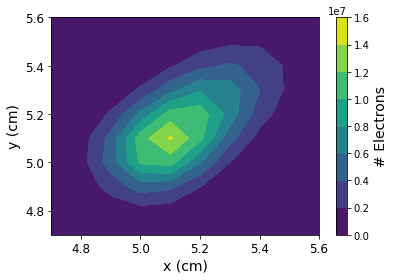

In [ ]:
fig = plt.figure()
# ax = fig.add_subplot(111)
plt.contourf(ReadoutGrid[0][:,:,0],ReadoutGrid[1][:,:,0], np.sum(ReadoutEvt, axis=2))
#ax.plot([0.5],[-0.2],'x')
plt.xlabel('x (cm)', fontsize=14)
plt.ylabel('y (cm)', fontsize=14)
cb = plt.colorbar(label='# Electrons')
cb.set_label('# Electrons', fontsize=14)
# plt.title('X-Y projection')
ax = plt.gca()
ax.tick_params(labelsize=12)
plt.savefig('ReadoutExample_amplified.png', dpi=400)

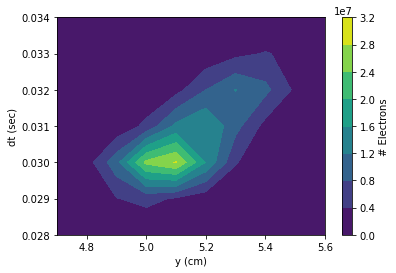

In [ ]:
fig = plt.figure()
# ax = fig.add_subplot(111)
plt.contourf(ReadoutGrid[1][0,:,:],ReadoutGrid[2][0,:,:], np.sum(ReadoutEvt, axis=0))
#ax.plot([0.5],[-0.2],'x')
plt.xlabel('y (cm)')
plt.ylabel('dt (sec)')
plt.colorbar(label='# Electrons')
# plt.title('Y-dT projection')

Text(0.5, 1.0, 'X-dT projection')

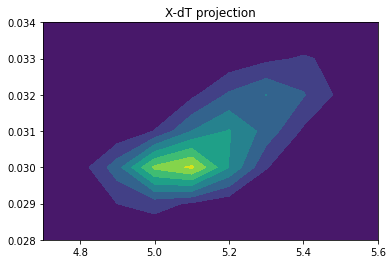

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(ReadoutGrid[0][:,0,:],ReadoutGrid[2][:,0,:], np.sum(ReadoutEvt, axis=1))
#ax.plot([0.5],[-0.2],'x')
plt.title('X-dT projection')

In [ ]:
np.max(ReadoutEvt)

9416812.069172405

In [ ]:
np.min(ReadoutEvt)

9.513316497187088e-23

In [ ]:
# This is necessary to set up 3D rotatable plots
%matplotlib widget

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection="3d")

themask = ReadoutEvt>1e4
sc = ax.scatter(ReadoutGrid[0][themask], ReadoutGrid[1][themask], ReadoutGrid[2][themask], 
           c=ReadoutEvt[themask], s=((ReadoutEvt[themask]/np.max(ReadoutEvt))**0.5)*1000, alpha=0.5, lw=0)#, marker='.')
cb = plt.colorbar(sc, shrink=0.5, drawedges=False, spacing='proportional', label='Number of Electrons')
# for line in cb.lines: 
#    line.set_linewidth(100)
cb.solids.set_linewidth(3)
plt.show()

In [ ]:
ReadoutDF = pd.DataFrame({'x': ReadoutGrid[0][themask], 'y': ReadoutGrid[1][themask], 
                          'dt': ReadoutGrid[2][themask], 'Nel':ReadoutEvt[themask]})

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection="3d")

themask = ReadoutEvt>1e4
sc = ax.scatter(ReadoutDF['x'], ReadoutDF['y'], ReadoutDF['dt'], 
           c=ReadoutDF['Nel'], s=((ReadoutDF['Nel']/np.max(ReadoutDF['Nel']))**0.5)*1000, alpha=0.5, lw=0)#, marker='.')
cb = plt.colorbar(sc, shrink=0.5, drawedges=False, spacing='proportional', label='Number of Electrons')
# for line in cb.lines: 
#    line.set_linewidth(100)
cb.solids.set_linewidth(3)
plt.show()

In [ ]:
%matplotlib inline

If I just plot a scatter plot of the dataframe, it is wrong because I'm not accumulating over the dt axis:

Text(0.5, 1.0, 'X-dT projection')

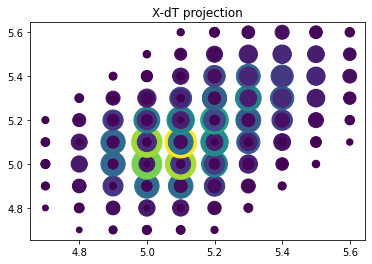

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ReadoutDF.x,ReadoutDF.y, c=ReadoutDF.Nel, s=((ReadoutDF['Nel']/np.max(ReadoutDF['Nel']))**0.5)*1000)
#ax.scatter(ret[:,0],ret[0,:], c=np.sum(ReadoutEvt[themask], axis=1))
#ax.plot([0.5],[-0.2],'x')
plt.title('X-dT projection')

After *much* dicking around with pandas, it turns out the way to do this is using groupby:

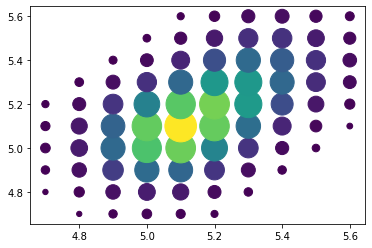

In [ ]:
projectxy = pd.DataFrame(ReadoutDF.groupby(['x','y'])['Nel'].sum()).reset_index()
plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*1000)

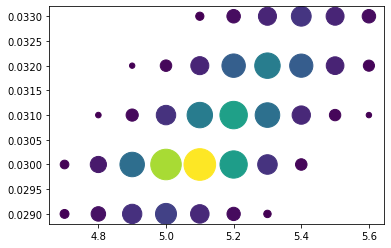

In [ ]:
projectxdt = pd.DataFrame(ReadoutDF.groupby(['x','dt'])['Nel'].sum()).reset_index()
plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*1000)

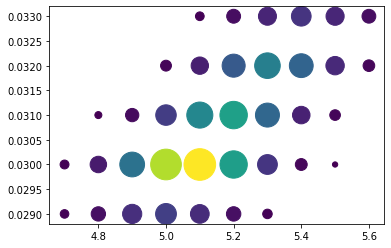

In [ ]:
projectydt = pd.DataFrame(ReadoutDF.groupby(['y','dt'])['Nel'].sum()).reset_index()
plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*1000)

Other useful code from mucking around with pandas...

Selecting a subset of columns is done using loc:

In [ ]:
ReadoutDF.loc[:, ['x', 'y']]

,x,y
0,4.7,4.8
1,4.7,4.9
2,4.7,4.9
3,4.7,5.0
4,4.7,5.0
...,...,...
240,5.6,5.4
241,5.6,5.4
242,5.6,5.5
243,5.6,5.5


Instead of unique() use drop_duplicates():

In [ ]:
ReadoutDF.loc[:, ['x', 'y']].drop_duplicates()

,x,y
0,4.7,4.8
1,4.7,4.9
3,4.7,5.0
5,4.7,5.1
7,4.7,5.2
...,...,...
236,5.6,5.2
238,5.6,5.3
240,5.6,5.4
242,5.6,5.5


Aggregate might be useful in the future for getting the barycentre of the track:

In [ ]:
print(ReadoutDF.aggregate(np.mean, axis=0))

x           5.177922
y           5.183983
dt          0.030905
Nel    932215.446250
dtype: float64


OK, that looks really cool!

Currently, I'm limited in the readout step -- doing this avalanche gain step requires making a grid over which the readout happens, and 3D grid can be pretty memory intensive if it's over many readout channels.

# ROOT File Reader

I'll just start with Ferdos' format and generalise from there...

In [43]:
f = TFile.Open("simOut_28796KShell.root")

In [44]:
f.ls()

TFile**		simOut_28796KShell.root	
 TFile*		simOut_28796KShell.root	
  KEY: TTree	data;15	tree [current cycle]
  KEY: TTree	data;14	tree [backup cycle]
  KEY: TTree	gamma_info;1	tree for storing the information of the gamma rays created in the concrete wall straight from the beam
  KEY: TH1D	NumInts;1	Number of Interactions per event
  KEY: TH1D	NumCorrs;1	Number of Correlated Interactions per event
  KEY: TH1D	MinApproach;1	Minimum possible approach distance between each event generated in the scintillant
  KEY: TH1D	IntDist;1	Distances between interactions


In [45]:
f.data.Print()

******************************************************************************
*Tree    :data      : tree                                                   *
*Entries :  1000000 : Total =       585971731 bytes  File  Size =  429697765 *
*        :          : Tree compression factor =   1.36                       *
******************************************************************************
*Br    0 :edep      : vector<double>                                         *
*Entries :  1000000 : Total  Size=   92898799 bytes  File Size  =   70424031 *
*Baskets :      226 : Basket Size=    7056896 bytes  Compression=   1.32     *
*............................................................................*
*Br    1 :x         : vector<double>                                         *
*Entries :  1000000 : Total  Size=   92898109 bytes  File Size  =   75730988 *
*Baskets :      226 : Basket Size=    7055872 bytes  Compression=   1.23     *
*...................................................

In [ ]:
for evt in f.data:
    #     print(np.array(evt.x))
    PrimaryEvt = pd.DataFrame({'x': np.asarray(evt.x), 'y': np.asarray(evt.y), 'z': np.asarray(evt.z), 
                               'Edep': np.asarray(evt.edep)})
    break

In [ ]:
PrimaryEvt

,x,y,z,Edep
0,-138.117056,34.845512,80.823438,0.000073
1,-138.117056,34.845512,73.164423,0.000038
2,-138.116612,34.846037,73.164081,0.000183
3,-138.117056,34.845512,73.164423,0.000069
4,-138.117245,34.845358,73.165208,0.000149
5,-138.117056,34.845512,73.164423,0.000049
6,-138.117056,34.845512,73.164423,0.000076
7,-138.131471,34.835705,73.172743,0.000600
8,-138.169468,34.820097,73.188191,0.000123
9,-138.152171,34.803286,73.177365,0.001038


In [ ]:
%timeit ret =np.asarray(evt.x) 

4.68 µs ± 70.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
evt.x[0]

-138.11705600727214

In [ ]:
thearr = np.asarray(evt.x)

In [ ]:
thearr

array([-138.11705601, -138.11705601, -138.1166118 , -138.11705601,
       -138.11724465, -138.11705601, -138.11705601, -138.13147098,
       -138.1694678 , -138.15217128, -138.14176018, -138.13226029,
       -138.1332843 , -138.11705601])

In [ ]:
evt.x[0] = -138.112

In [ ]:
thearr

array([-138.112     , -138.11705601, -138.1166118 , -138.11705601,
       -138.11724465, -138.11705601, -138.11705601, -138.13147098,
       -138.1694678 , -138.15217128, -138.14176018, -138.13226029,
       -138.1332843 , -138.11705601])

In [ ]:
%timeit ret = list(evt.x)

2.89 µs ± 51.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# To Do

This is a solid start. Here's a list of things that I should work on next to develop the code

1. Write a library to allow the code to be called externally. I might be able to encapsulate things within a class, but maybe I don't want to do that to give the person calling the code more flexibility? This needs to be a priority, since running externally will allow studies to start (and it'll be clear whether the code needs to be sped up).

2. Investigate whether there is/how to implement correlation between the X-Y and dT smearing. It's probably the case and I can imagine it leads to image artefacts.

3. Implement a more realistic 'PSF' on last step.

4. I could investigate using a 'sparse histogram' for the last step, to speed things up?

5. Future physics updates: drift field distortions, the photon light yield (primary and secondary), charge sharing/crosstalk between readout channels, readout digitization/noise.

6. Future speed/convenience updates: special case of 2D projective readout (can entirely skip 3rd dimension and speed things up), more detailed readout for detailed view of certain events, automatic warnings if arrays will be too big, investigate whether PrimaryEvt and DriftedEvt can be combined using a pivot table (I'm not sure if that's the right term).